In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def save_labels(arr, filename):
    pd_array = pd.DataFrame(arr)
    pd_array.index.names = ["Id"]
    pd_array.columns = ["Prediction"]
    pd_array.to_csv(filename)

def load_labels(filename):
    return pd.read_csv(filename, index_col=0).values.ravel()

In [2]:


X_train = np.load("/mnt/dane_ml/X_train.npy")
y_train = load_labels("/mnt/dane_ml/y_train.csv")
X_test = np.load("/mnt/dane_ml/X_test.npy")

# Mój keras ma kolorki na końcu
X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).transpose(0,2,3,1)


In [3]:
#if not os.path.isfile("baseline.pkl"):
#    lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(verbose=43))])
#    lr.fit(X_train, y_train)
#    print("Train acc:", accuracy_score(y_train, lr.predict(X_train)))
#    with open("baseline.pkl", 'w') as f_out:
#        pickle.dump(lr, f_out)
#else:
#    with open("baseline.pkl", 'r') as f_in:
#        lr = pickle.load(f_in)
#
#save_labels(model.predict(X_test), "y_pred.csv")

# CZĘŚĆ PIERWSZA

xgboost?

In [3]:
os.environ['KERAS_BACKEND'] = 'theano'
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
first_X_train, first_X_test, first_y_train, first_y_test = train_test_split(X_train[:1200], y_train[:1200], test_size=0.33, random_state=43)
first_y_train = to_categorical(first_y_train, num_classes=10)
first_y_test = to_categorical(first_y_test, num_classes=10)



Using Theano backend.


(32, 32, 3)


In [39]:
input_shape=first_X_train[0].shape
print input_shape

print first_y_test[5]

(32, 32, 3)
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


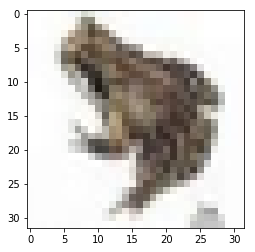

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(first_X_train[54])

In [41]:
os.environ['KERAS_BACKEND'] = 'theano'

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

model = Sequential()
model.add(Conv2D(48, kernel_size=(5, 5), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(48, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, kernel_size=(3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, kernel_size=(3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [42]:
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 28, 28, 48)        3648      
_________________________________________________________________
activation_140 (Activation)  (None, 28, 28, 48)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 26, 26, 48)        20784     
_________________________________________________________________
activation_141 (Activation)  (None, 26, 26, 48)        0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 13, 13, 48)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 13, 13, 96)        41568     
__________

In [43]:
model.fit(first_X_train, first_y_train,
          batch_size=128,
          epochs=15,
          verbose=1,
          validation_data=(first_X_test, first_y_test))#first_X_test, first_y_test))


Train on 804 samples, validate on 396 samples
Epoch 1/15
804/804 [==============================] - 31s - loss: 4.9895 - acc: 0.1057 - val_loss: 2.3049 - val_acc: 0.0758
Epoch 2/15
804/804 [==============================] - 33s - loss: 2.3168 - acc: 0.1020 - val_loss: 2.3003 - val_acc: 0.1263
Epoch 3/15
804/804 [==============================] - 33s - loss: 2.3077 - acc: 0.1107 - val_loss: 2.3007 - val_acc: 0.1010
Epoch 4/15
804/804 [==============================] - 32s - loss: 2.2962 - acc: 0.1157 - val_loss: 2.2957 - val_acc: 0.1465
Epoch 5/15
804/804 [==============================] - 32s - loss: 2.2971 - acc: 0.1132 - val_loss: 2.2973 - val_acc: 0.1237
Epoch 6/15
804/804 [==============================] - 32s - loss: 2.2908 - acc: 0.1144 - val_loss: 2.2985 - val_acc: 0.1313
Epoch 7/15
804/804 [==============================] - 32s - loss: 2.2877 - acc: 0.1182 - val_loss: 2.2900 - val_acc: 0.1515
Epoch 8/15
804/804 [==============================] - 32s - loss: 2.2700 - acc: 0.1493

In [12]:
score = model.evaluate(first_X_test, first_y_test, verbose=0)
print score

[14.693516509701507, 0.088383838383838384]


In [11]:
score = model.evaluate(first_X_train, first_y_train, verbose=0)
print score

[2.3017220425961624, 0.10696517412935323]
